## The Sacramento Kings Playoff Drought
### By: Jonathan Donato, Matthew Morisawa, Tony Liu

In [1]:
#import all libraries necessary for project

import requests as rq
import lxml.html as lx
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
import seaborn as sn
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm 
pd.set_option('display.max_columns', None)
import plotnine as p9

## Obtain Kings Players Stats + Salary

In [2]:
#read html + make df for general stats
url = 'https://www.espn.com/nba/team/stats/_/name/sac/salary'
names = pd.read_html(url)[0]
stats = pd.read_html(url)[1]
kings_stats_temp = pd.concat([names,stats],axis = "columns")
kings_stats_temp

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO
0,De'Aaron Fox PG,21,21.0,31.7,23.1,0.5,4.6,5.1,5.8,1.1,0.5,2.6,2.5,2.2
1,Domantas Sabonis PF,22,22.0,32.0,16.7,2.2,8.8,11.0,6.5,0.7,0.5,2.5,3.8,2.6
2,Kevin Huerter SG,22,22.0,31.8,15.5,0.4,2.8,3.2,3.2,1.0,0.4,1.5,2.4,2.2
3,Malik Monk SG,22,0.0,22.3,14.7,0.4,1.7,2.1,4.3,0.7,0.2,1.9,1.8,2.3
4,Harrison Barnes SF,22,22.0,30.6,13.2,1.0,4.4,5.5,1.9,0.9,0.1,1.2,1.4,1.5
5,Keegan Murray SF,20,18.0,28.4,11.3,0.9,3.2,4.1,0.9,0.8,0.6,1.6,2.1,0.6
6,Terence Davis SG,20,1.0,13.2,7.0,0.5,2.6,3.0,1.5,0.8,0.2,0.8,1.8,2.0
7,Davion Mitchell PG,22,1.0,19.2,6.7,0.1,1.3,1.4,2.3,0.5,0.2,1.0,1.6,2.2
8,Trey Lyles PF,17,0.0,14.2,6.3,1.0,1.8,2.8,0.8,0.4,0.4,1.0,1.2,0.8
9,Chimezie Metu PF,18,0.0,12.6,5.9,0.7,2.8,3.5,0.8,0.3,0.3,0.7,1.2,1.2


In [3]:
def remove_positions(df):
    '''Removes The position indicator after each player's name (i.e. PG, PF, SG), also drops the "Total" row as it's not needed.'''
    words = []
    for i in df["Name"]:
        words.append(i.split()[0:2])
    words = pd.DataFrame(words)
    words.columns = ["First","Last"]
    words["Names"] = words['First']+" "+ words["Last"]
    words = words.drop("First", axis = 1).drop("Last", axis = 1)
    df["Name"] = words
    #df = df.drop(16)
    df = df.dropna().reset_index().drop("index", axis = "columns")
    return df

kings_stats = remove_positions(kings_stats_temp)
kings_stats

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO
0,De'Aaron Fox,21,21.0,31.7,23.1,0.5,4.6,5.1,5.8,1.1,0.5,2.6,2.5,2.2
1,Domantas Sabonis,22,22.0,32.0,16.7,2.2,8.8,11.0,6.5,0.7,0.5,2.5,3.8,2.6
2,Kevin Huerter,22,22.0,31.8,15.5,0.4,2.8,3.2,3.2,1.0,0.4,1.5,2.4,2.2
3,Malik Monk,22,0.0,22.3,14.7,0.4,1.7,2.1,4.3,0.7,0.2,1.9,1.8,2.3
4,Harrison Barnes,22,22.0,30.6,13.2,1.0,4.4,5.5,1.9,0.9,0.1,1.2,1.4,1.5
5,Keegan Murray,20,18.0,28.4,11.3,0.9,3.2,4.1,0.9,0.8,0.6,1.6,2.1,0.6
6,Terence Davis,20,1.0,13.2,7.0,0.5,2.6,3.0,1.5,0.8,0.2,0.8,1.8,2.0
7,Davion Mitchell,22,1.0,19.2,6.7,0.1,1.3,1.4,2.3,0.5,0.2,1.0,1.6,2.2
8,Trey Lyles,17,0.0,14.2,6.3,1.0,1.8,2.8,0.8,0.4,0.4,1.0,1.2,0.8
9,Chimezie Metu,18,0.0,12.6,5.9,0.7,2.8,3.5,0.8,0.3,0.3,0.7,1.2,1.2


In [4]:
# read html + make df for shooting stats
shoot = pd.read_html(url)[3]
kings_shoot_stats_temp = pd.concat([names,shoot], axis = "columns")

In [5]:
kings_shoot_stats = remove_positions(kings_shoot_stats_temp)
kings_shoot_stats

,Name,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
0,De'Aaron Fox,8.6,16.6,51.6,1.9,5.0,38.1,4.1,5.0,81.9,6.7,11.6,57.4,1.393,0.57
1,Domantas Sabonis,6.0,10.1,59.9,0.5,1.2,37.0,4.2,5.5,75.4,5.6,8.9,63.1,1.658,0.62
2,Kevin Huerter,5.5,11.5,47.4,3.0,7.1,42.3,1.6,2.4,69.2,2.5,4.4,55.7,1.352,0.60
3,Malik Monk,5.4,11.0,48.8,2.1,5.7,36.8,1.9,2.1,89.4,3.3,5.3,61.5,1.339,0.58
4,Harrison Barnes,4.1,8.4,48.9,1.0,3.3,30.1,4.0,4.8,84.0,3.1,5.0,61.3,1.582,0.55
5,Keegan Murray,4.1,9.9,41.4,1.9,5.7,33.3,1.2,1.4,85.2,2.2,4.2,52.4,1.136,0.51
6,Terence Davis,2.5,5.6,43.8,1.4,3.6,39.4,0.7,0.8,87.5,1.1,2.1,51.2,1.250,0.56
7,Davion Mitchell,2.7,6.0,44.7,0.8,2.7,30.5,0.5,0.7,73.3,1.9,3.3,56.2,1.114,0.52
8,Trey Lyles,2.1,5.1,40.7,1.2,3.6,34.4,0.9,1.3,72.7,0.8,1.5,56.0,1.244,0.53
9,Chimezie Metu,2.5,4.0,62.5,0.2,0.9,18.8,0.8,0.9,87.5,2.3,3.1,75.0,1.486,0.65


In [6]:
#create salary df
url2 = "https://www.espn.com/nba/team/roster/_/name/sac/salary"
kings_salary_raw = pd.read_html(url2)[0]

In [7]:
#Strips player number from each players name
for i in range(0,len(kings_salary_raw)):
    kings_salary_raw["Name"][i] = re.sub(r"\d+", "", str(kings_salary_raw["Name"][i]))

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_2368\1132565592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#Cleans dataframe to only player name + salary
kings_salary = kings_salary_raw.set_index("Name").drop('Unnamed: 0', axis = 1)
kings_salary.columns
kings_salary = kings_salary.drop(['POS', 'Age', 'HT', 'WT', 'College'], axis = 1)
kings_salary

,Salary
Name,
Keon Ellis,--
Neemias Queta,--
Chima Moneke,"$1,017,781"
KZ Okpala,"$1,782,621"
Matthew Dellavedova,"$1,836,090"
Chimezie Metu,"$1,910,680"
Trey Lyles,"$2,700,000"
Alex Len,"$3,918,000"
Terence Davis,"$4,000,000"


In [9]:
#combine player stats df and salary df as kings_stats_salary. 
pd.set_option('display.max_columns', None)
kings_stats_salary = kings_stats.join(kings_salary, on = "Name")
kings_stats_salary

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,Salary
0,De'Aaron Fox,21,21.0,31.7,23.1,0.5,4.6,5.1,5.8,1.1,0.5,2.6,2.5,2.2,"$28,103,550"
1,Domantas Sabonis,22,22.0,32.0,16.7,2.2,8.8,11.0,6.5,0.7,0.5,2.5,3.8,2.6,"$18,500,000"
2,Kevin Huerter,22,22.0,31.8,15.5,0.4,2.8,3.2,3.2,1.0,0.4,1.5,2.4,2.2,"$14,508,929"
3,Malik Monk,22,0.0,22.3,14.7,0.4,1.7,2.1,4.3,0.7,0.2,1.9,1.8,2.3,"$9,472,219"
4,Harrison Barnes,22,22.0,30.6,13.2,1.0,4.4,5.5,1.9,0.9,0.1,1.2,1.4,1.5,"$18,352,273"
5,Keegan Murray,20,18.0,28.4,11.3,0.9,3.2,4.1,0.9,0.8,0.6,1.6,2.1,0.6,"$8,008,440"
6,Terence Davis,20,1.0,13.2,7.0,0.5,2.6,3.0,1.5,0.8,0.2,0.8,1.8,2.0,"$4,000,000"
7,Davion Mitchell,22,1.0,19.2,6.7,0.1,1.3,1.4,2.3,0.5,0.2,1.0,1.6,2.2,"$4,833,600"
8,Trey Lyles,17,0.0,14.2,6.3,1.0,1.8,2.8,0.8,0.4,0.4,1.0,1.2,0.8,"$2,700,000"
9,Chimezie Metu,18,0.0,12.6,5.9,0.7,2.8,3.5,0.8,0.3,0.3,0.7,1.2,1.2,"$1,910,680"


In [10]:
#combine kings shooting stats df with "kings_stats_salary".
kings_player_shooting_salary = pd.merge(kings_stats_salary,kings_shoot_stats, how = "left", on = "Name")
kings_player_shooting_salary

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,Salary,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
0,De'Aaron Fox,21,21.0,31.7,23.1,0.5,4.6,5.1,5.8,1.1,0.5,2.6,2.5,2.2,"$28,103,550",8.6,16.6,51.6,1.9,5.0,38.1,4.1,5.0,81.9,6.7,11.6,57.4,1.393,0.57
1,Domantas Sabonis,22,22.0,32.0,16.7,2.2,8.8,11.0,6.5,0.7,0.5,2.5,3.8,2.6,"$18,500,000",6.0,10.1,59.9,0.5,1.2,37.0,4.2,5.5,75.4,5.6,8.9,63.1,1.658,0.62
2,Kevin Huerter,22,22.0,31.8,15.5,0.4,2.8,3.2,3.2,1.0,0.4,1.5,2.4,2.2,"$14,508,929",5.5,11.5,47.4,3.0,7.1,42.3,1.6,2.4,69.2,2.5,4.4,55.7,1.352,0.60
3,Malik Monk,22,0.0,22.3,14.7,0.4,1.7,2.1,4.3,0.7,0.2,1.9,1.8,2.3,"$9,472,219",5.4,11.0,48.8,2.1,5.7,36.8,1.9,2.1,89.4,3.3,5.3,61.5,1.339,0.58
4,Harrison Barnes,22,22.0,30.6,13.2,1.0,4.4,5.5,1.9,0.9,0.1,1.2,1.4,1.5,"$18,352,273",4.1,8.4,48.9,1.0,3.3,30.1,4.0,4.8,84.0,3.1,5.0,61.3,1.582,0.55
5,Keegan Murray,20,18.0,28.4,11.3,0.9,3.2,4.1,0.9,0.8,0.6,1.6,2.1,0.6,"$8,008,440",4.1,9.9,41.4,1.9,5.7,33.3,1.2,1.4,85.2,2.2,4.2,52.4,1.136,0.51
6,Terence Davis,20,1.0,13.2,7.0,0.5,2.6,3.0,1.5,0.8,0.2,0.8,1.8,2.0,"$4,000,000",2.5,5.6,43.8,1.4,3.6,39.4,0.7,0.8,87.5,1.1,2.1,51.2,1.250,0.56
7,Davion Mitchell,22,1.0,19.2,6.7,0.1,1.3,1.4,2.3,0.5,0.2,1.0,1.6,2.2,"$4,833,600",2.7,6.0,44.7,0.8,2.7,30.5,0.5,0.7,73.3,1.9,3.3,56.2,1.114,0.52
8,Trey Lyles,17,0.0,14.2,6.3,1.0,1.8,2.8,0.8,0.4,0.4,1.0,1.2,0.8,"$2,700,000",2.1,5.1,40.7,1.2,3.6,34.4,0.9,1.3,72.7,0.8,1.5,56.0,1.244,0.53
9,Chimezie Metu,18,0.0,12.6,5.9,0.7,2.8,3.5,0.8,0.3,0.3,0.7,1.2,1.2,"$1,910,680",2.5,4.0,62.5,0.2,0.9,18.8,0.8,0.9,87.5,2.3,3.1,75.0,1.486,0.65


In [11]:
#Rearrange salary to column to go at the end.
salary = kings_player_shooting_salary.pop("Salary")
kings_final_df = pd.concat([kings_player_shooting_salary, salary], axis = 'columns')
kings_final_df

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,De'Aaron Fox,21,21.0,31.7,23.1,0.5,4.6,5.1,5.8,1.1,0.5,2.6,2.5,2.2,8.6,16.6,51.6,1.9,5.0,38.1,4.1,5.0,81.9,6.7,11.6,57.4,1.393,0.57,"$28,103,550"
1,Domantas Sabonis,22,22.0,32.0,16.7,2.2,8.8,11.0,6.5,0.7,0.5,2.5,3.8,2.6,6.0,10.1,59.9,0.5,1.2,37.0,4.2,5.5,75.4,5.6,8.9,63.1,1.658,0.62,"$18,500,000"
2,Kevin Huerter,22,22.0,31.8,15.5,0.4,2.8,3.2,3.2,1.0,0.4,1.5,2.4,2.2,5.5,11.5,47.4,3.0,7.1,42.3,1.6,2.4,69.2,2.5,4.4,55.7,1.352,0.60,"$14,508,929"
3,Malik Monk,22,0.0,22.3,14.7,0.4,1.7,2.1,4.3,0.7,0.2,1.9,1.8,2.3,5.4,11.0,48.8,2.1,5.7,36.8,1.9,2.1,89.4,3.3,5.3,61.5,1.339,0.58,"$9,472,219"
4,Harrison Barnes,22,22.0,30.6,13.2,1.0,4.4,5.5,1.9,0.9,0.1,1.2,1.4,1.5,4.1,8.4,48.9,1.0,3.3,30.1,4.0,4.8,84.0,3.1,5.0,61.3,1.582,0.55,"$18,352,273"
5,Keegan Murray,20,18.0,28.4,11.3,0.9,3.2,4.1,0.9,0.8,0.6,1.6,2.1,0.6,4.1,9.9,41.4,1.9,5.7,33.3,1.2,1.4,85.2,2.2,4.2,52.4,1.136,0.51,"$8,008,440"
6,Terence Davis,20,1.0,13.2,7.0,0.5,2.6,3.0,1.5,0.8,0.2,0.8,1.8,2.0,2.5,5.6,43.8,1.4,3.6,39.4,0.7,0.8,87.5,1.1,2.1,51.2,1.250,0.56,"$4,000,000"
7,Davion Mitchell,22,1.0,19.2,6.7,0.1,1.3,1.4,2.3,0.5,0.2,1.0,1.6,2.2,2.7,6.0,44.7,0.8,2.7,30.5,0.5,0.7,73.3,1.9,3.3,56.2,1.114,0.52,"$4,833,600"
8,Trey Lyles,17,0.0,14.2,6.3,1.0,1.8,2.8,0.8,0.4,0.4,1.0,1.2,0.8,2.1,5.1,40.7,1.2,3.6,34.4,0.9,1.3,72.7,0.8,1.5,56.0,1.244,0.53,"$2,700,000"
9,Chimezie Metu,18,0.0,12.6,5.9,0.7,2.8,3.5,0.8,0.3,0.3,0.7,1.2,1.2,2.5,4.0,62.5,0.2,0.9,18.8,0.8,0.9,87.5,2.3,3.1,75.0,1.486,0.65,"$1,910,680"


In [12]:
#aquring links in raw form
url = "https://www.espn.com/nba/teams"
result = requests.get(url)
soup = BeautifulSoup(result.text, 'html.parser')
links = [str(link.get('href')) for link in soup.find_all("a")]
links_df = pd.DataFrame(links)
links_df.columns = ["links"]
pattern = re.compile(r'/nba/team/stats/_/name/+')
stats_links_df = links_df[links_df['links'].str.contains(pattern, regex = True)]
print(links_df)
stats_links_df

                                                 links
0                                                 None
1                                                    /
2                                                /nfl/
3                                   /college-football/
4                                                /nhl/
..                                                 ...
247              http://www.nielsen.com/digitalprivacy
248  https://privacy.thewaltdisneycompany.com/en/dn...
249  https://www.espn.com/espn/news/story?page=cont...
250                         https://disneyadsales.com/
251                https://jobs.disneycareers.com/espn

[252 rows x 1 columns]


,links
28,/nba/team/stats/_/name/bos/boston-celtics
35,/nba/team/stats/_/name/bkn/brooklyn-nets
42,/nba/team/stats/_/name/ny/new-york-knicks
49,/nba/team/stats/_/name/phi/philadelphia-76ers
56,/nba/team/stats/_/name/tor/toronto-raptors
63,/nba/team/stats/_/name/chi/chicago-bulls
70,/nba/team/stats/_/name/cle/cleveland-cavaliers
77,/nba/team/stats/_/name/det/detroit-pistons
84,/nba/team/stats/_/name/ind/indiana-pacers
91,/nba/team/stats/_/name/mil/milwaukee-bucks


In [13]:
stats_links_df = stats_links_df.reset_index().drop("index", axis = "columns")
west_conference = pd.concat([stats_links_df.iloc[10:20,:],stats_links_df.iloc[25:,:]])
west_conference_stats_links = west_conference.reset_index().drop("index", axis = "columns")
#links to team stats that are only in the western conference
west_conference_stats_links

,links
0,/nba/team/stats/_/name/den/denver-nuggets
1,/nba/team/stats/_/name/min/minnesota-timberwolves
2,/nba/team/stats/_/name/okc/oklahoma-city-thunder
3,/nba/team/stats/_/name/por/portland-trail-blazers
4,/nba/team/stats/_/name/utah/utah-jazz
5,/nba/team/stats/_/name/gs/golden-state-warriors
6,/nba/team/stats/_/name/lac/la-clippers
7,/nba/team/stats/_/name/lal/los-angeles-lakers
8,/nba/team/stats/_/name/phx/phoenix-suns
9,/nba/team/stats/_/name/sac/sacramento-kings


In [14]:
#Removing kings from links
west_conference_stats_links = west_conference_stats_links.drop(9, axis = "rows").reset_index().drop("index",axis = "columns")

In [15]:
#acquire raw data
players_df = pd.DataFrame()
for link in west_conference_stats_links["links"]:
    url = "https://www.espn.com"+link
    player_names = pd.read_html(url)[0]
    player_stats = pd.read_html(url)[1]
    player_concat = pd.concat([player_names,player_stats],axis = "columns")
    players_df = pd.concat([players_df, player_concat], ignore_index = True)




remove_positions(players_df)
#Cleaned up dataframe with all player stats in western conference
pd.set_option('display.max_rows', None)
players_df

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO
0,Nikola Jokic,21,21.0,32.2,23.0,1.9,8.1,10.0,8.9,1.3,0.6,3.2,2.9,2.7
1,Jamal Murray,20,20.0,29.9,17.6,0.5,3.2,3.7,5.0,1.0,0.3,2.0,1.5,2.5
2,Aaron Gordon,21,21.0,29.3,16.6,2.4,4.3,6.7,2.3,0.7,0.8,1.4,1.8,1.6
3,Michael Porter,16,16.0,29.1,16.4,1.2,4.8,6.0,1.3,0.6,0.4,1.1,2.6,1.1
4,Bones Hyland,16,0.0,21.1,14.4,0.3,1.8,2.1,3.4,0.7,0.3,1.9,1.7,1.8
5,Bruce Brown,24,12.0,30.0,11.3,1.0,3.5,4.5,4.5,1.1,0.5,1.8,2.5,2.5
6,Kentavious Caldwell-Pope,23,23.0,31.1,11.0,0.5,2.3,2.9,2.1,1.2,0.4,1.3,2.0,1.6
7,Jeff Green,17,3.0,19.8,7.9,0.7,1.8,2.5,1.2,0.4,0.2,1.0,2.1,1.2
8,DeAndre Jordan,19,3.0,15.7,5.3,1.6,4.3,5.9,1.0,0.2,0.6,1.3,1.6,0.8
9,Vlatko Cancar,16,0.0,12.4,5.0,0.3,1.4,1.8,0.9,0.4,0.3,0.6,1.4,1.5


In [16]:
players_df_shoot = pd.DataFrame()
for link in west_conference_stats_links["links"]:
    url = "https://www.espn.com"+link
    player_names = pd.read_html(url)[0]
    player_shoot = pd.read_html(url)[3]
    player_concat = pd.concat([player_names,player_shoot],axis = "columns")
    
    players_df_shoot = pd.concat([players_df_shoot, player_concat], ignore_index = True)

remove_positions(players_df_shoot)
#Cleaned up dataframe with all player stats in western conference
players_df_shoot

,Name,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
0,Nikola Jokic,8.6,13.7,63.1,0.8,2.4,32.0,5.0,6.2,80.8,7.9,11.3,69.6,1.683,0.66
1,Jamal Murray,6.6,15.3,43.3,1.9,5.3,36.2,2.5,3.2,78.1,4.7,10.0,47.0,1.154,0.50
2,Aaron Gordon,6.4,10.3,61.8,1.1,2.8,39.7,2.8,4.3,63.7,5.3,7.6,69.8,1.608,0.67
3,Michael Porter,6.0,12.9,46.6,2.9,6.9,42.7,1.5,1.9,80.0,3.1,6.0,51.0,1.277,0.58
4,Bones Hyland,4.8,11.8,40.4,2.8,6.4,44.1,2.1,2.6,81.0,1.9,5.4,36.0,1.229,0.52
5,Bruce Brown,4.4,9.4,47.1,1.4,3.4,40.7,1.0,1.2,89.3,3.0,6.0,50.7,1.200,0.54
6,Kentavious Caldwell-Pope,3.9,8.4,46.4,2.1,4.6,45.7,1.1,1.4,78.1,1.8,3.9,47.2,1.304,0.59
7,Jeff Green,2.9,5.5,53.8,0.4,1.3,27.3,1.6,2.2,75.7,2.6,4.2,62.0,1.441,0.57
8,DeAndre Jordan,2.3,3.0,75.4,0.1,0.1,100.0,0.7,1.6,46.7,2.2,2.9,75.0,1.772,0.76
9,Vlatko Cancar,1.9,4.1,46.2,0.9,2.1,41.2,0.4,0.4,85.7,1.0,1.9,51.6,1.231,0.57


In [17]:
#Next few cells are for acquiring salary of all players in western conference

url2 = "https://www.espn.com/nba/team/roster/_/name/sac/salary"
kings_salary_raw = pd.read_html(url2)[0]

pattern_sal = re.compile(r'/nba/team/roster/_/+')
sal_links_df = links_df[links_df['links'].str.contains(pattern_sal, regex = True)]


west_conference_sal = pd.concat([sal_links_df.iloc[10:20,:],sal_links_df.iloc[25:,:]])
west_conference_sal_links = west_conference_sal.reset_index().drop("index", axis = "columns")
#links to all pages with team salaries
west_conference_sal_links

,links
0,/nba/team/roster/_/name/den/denver-nuggets
1,/nba/team/roster/_/name/min/minnesota-timberwo...
2,/nba/team/roster/_/name/okc/oklahoma-city-thunder
3,/nba/team/roster/_/name/por/portland-trail-bla...
4,/nba/team/roster/_/name/utah/utah-jazz
5,/nba/team/roster/_/name/gs/golden-state-warriors
6,/nba/team/roster/_/name/lac/la-clippers
7,/nba/team/roster/_/name/lal/los-angeles-lakers
8,/nba/team/roster/_/name/phx/phoenix-suns
9,/nba/team/roster/_/name/sac/sacramento-kings


In [18]:
#Removed kings from links
west_conference_sal_links = west_conference_sal_links.drop(9, axis = "rows").reset_index().drop("index",axis = "columns")
west_conference_sal_links

,links
0,/nba/team/roster/_/name/den/denver-nuggets
1,/nba/team/roster/_/name/min/minnesota-timberwo...
2,/nba/team/roster/_/name/okc/oklahoma-city-thunder
3,/nba/team/roster/_/name/por/portland-trail-bla...
4,/nba/team/roster/_/name/utah/utah-jazz
5,/nba/team/roster/_/name/gs/golden-state-warriors
6,/nba/team/roster/_/name/lac/la-clippers
7,/nba/team/roster/_/name/lal/los-angeles-lakers
8,/nba/team/roster/_/name/phx/phoenix-suns
9,/nba/team/roster/_/name/dal/dallas-mavericks


In [19]:
#What the salary page returns; we only care about name and salary
pd.read_html("https://www.espn.com/nba/team/roster/_/name/den/denver-nuggets")

[    Unnamed: 0                       Name POS  Age      HT       WT  \
 0          NaN           Christian Braun0   G   21   6' 6"  220 lbs   
 1          NaN              Bruce Brown11  SF   26   6' 4"  202 lbs   
 2          NaN  Kentavious Caldwell-Pope5  SG   29   6' 5"  204 lbs   
 3          NaN            Vlatko Cancar31  SF   25   6' 8"  236 lbs   
 4          NaN         Collin Gillespie21   G   23   6' 1"  195 lbs   
 5          NaN             Aaron Gordon50  PF   27   6' 8"  235 lbs   
 6          NaN               Jeff Green32  PF   36   6' 8"  235 lbs   
 7          NaN              Bones Hyland3  PG   22   6' 2"  169 lbs   
 8          NaN             Nikola Jokic15   C   27  6' 11"  284 lbs   
 9          NaN            DeAndre Jordan6   C   34  6' 11"  265 lbs   
 10         NaN             Jamal Murray27  PG   25   6' 4"  215 lbs   
 11         NaN               Zeke Nnaji22  PF   21   6' 9"  240 lbs   
 12         NaN        Michael Porter Jr.1  SF   24  6' 10"  218

In [20]:
#Acquiring the salaries from the links
sal_players_df = pd.DataFrame()
for link in west_conference_sal_links["links"]:
    url = "https://www.espn.com"+link
    player_salaries = pd.read_html(url)[0]
    sal_players_df = pd.concat([sal_players_df, player_salaries], ignore_index = True)
sal_players_df

,Unnamed: 0,Name,POS,Age,HT,WT,College,Salary
0,NaN,Christian Braun0,G,21,"6' 6""",220 lbs,Kansas,"$2,808,600"
1,NaN,Bruce Brown11,SF,26,"6' 4""",202 lbs,Miami (FL),"$6,479,000"
2,NaN,Kentavious Caldwell-Pope5,SG,29,"6' 5""",204 lbs,Georgia,"$14,004,703"
3,NaN,Vlatko Cancar31,SF,25,"6' 8""",236 lbs,--,"$2,234,359"
4,NaN,Collin Gillespie21,G,23,"6' 1""",195 lbs,Villanova,--
5,NaN,Aaron Gordon50,PF,27,"6' 8""",235 lbs,Arizona,"$19,690,909"
6,NaN,Jeff Green32,PF,36,"6' 8""",235 lbs,Georgetown,"$4,500,000"
7,NaN,Bones Hyland3,PG,22,"6' 2""",169 lbs,Virginia Commonwealth,"$2,201,520"
8,NaN,Nikola Jokic15,C,27,"6' 11""",284 lbs,--,"$33,047,804"
9,NaN,DeAndre Jordan6,C,34,"6' 11""",265 lbs,Texas A&M,"$1,836,090"


In [21]:
#Cleaning
for i in range(0,len(sal_players_df)):
    sal_players_df.loc[:,"Name"][i] = re.sub(r"\d+", "", str(sal_players_df.loc[:,"Name"][i]))

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_2368\3537221818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
#Cleaning
sal_players_df = sal_players_df.set_index("Name").drop('Unnamed: 0', axis = 1)
sal_players_df = sal_players_df.drop(['POS', 'Age', 'HT', 'WT', 'College'], axis = 1)
#Clean salary dataframe
sal_players_df

,Salary
Name,
Christian Braun,"$2,808,600"
Bruce Brown,"$6,479,000"
Kentavious Caldwell-Pope,"$14,004,703"
Vlatko Cancar,"$2,234,359"
Collin Gillespie,--
Aaron Gordon,"$19,690,909"
Jeff Green,"$4,500,000"
Bones Hyland,"$2,201,520"
Nikola Jokic,"$33,047,804"


In [23]:
#Merge western conference player stats with their salaries
players_stats_salary = pd.merge(players_df,sal_players_df, how = "left", on = "Name")
player_stats_shoot_salary = pd.merge(players_stats_salary, players_df_shoot, how = "left", on = "Name")
player_stats_shoot_salary
salary = player_stats_shoot_salary.pop("Salary")
player_stats_shoot_salary = pd.concat([player_stats_shoot_salary, salary], axis = 'columns')
player_stats_shoot_salary

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,Nikola Jokic,21,21.0,32.2,23.0,1.9,8.1,10.0,8.9,1.3,0.6,3.2,2.9,2.7,8.6,13.7,63.1,0.8,2.4,32.0,5.0,6.2,80.8,7.9,11.3,69.6,1.683,0.66,"$33,047,804"
1,Jamal Murray,20,20.0,29.9,17.6,0.5,3.2,3.7,5.0,1.0,0.3,2.0,1.5,2.5,6.6,15.3,43.3,1.9,5.3,36.2,2.5,3.2,78.1,4.7,10.0,47.0,1.154,0.50,"$31,650,000"
2,Aaron Gordon,21,21.0,29.3,16.6,2.4,4.3,6.7,2.3,0.7,0.8,1.4,1.8,1.6,6.4,10.3,61.8,1.1,2.8,39.7,2.8,4.3,63.7,5.3,7.6,69.8,1.608,0.67,"$19,690,909"
3,Michael Porter,16,16.0,29.1,16.4,1.2,4.8,6.0,1.3,0.6,0.4,1.1,2.6,1.1,6.0,12.9,46.6,2.9,6.9,42.7,1.5,1.9,80.0,3.1,6.0,51.0,1.277,0.58,NaN
4,Bones Hyland,16,0.0,21.1,14.4,0.3,1.8,2.1,3.4,0.7,0.3,1.9,1.7,1.8,4.8,11.8,40.4,2.8,6.4,44.1,2.1,2.6,81.0,1.9,5.4,36.0,1.229,0.52,"$2,201,520"
5,Bruce Brown,24,12.0,30.0,11.3,1.0,3.5,4.5,4.5,1.1,0.5,1.8,2.5,2.5,4.4,9.4,47.1,1.4,3.4,40.7,1.0,1.2,89.3,3.0,6.0,50.7,1.200,0.54,"$6,479,000"
6,Kentavious Caldwell-Pope,23,23.0,31.1,11.0,0.5,2.3,2.9,2.1,1.2,0.4,1.3,2.0,1.6,3.9,8.4,46.4,2.1,4.6,45.7,1.1,1.4,78.1,1.8,3.9,47.2,1.304,0.59,"$14,004,703"
7,Jeff Green,17,3.0,19.8,7.9,0.7,1.8,2.5,1.2,0.4,0.2,1.0,2.1,1.2,2.9,5.5,53.8,0.4,1.3,27.3,1.6,2.2,75.7,2.6,4.2,62.0,1.441,0.57,"$4,500,000"
8,DeAndre Jordan,19,3.0,15.7,5.3,1.6,4.3,5.9,1.0,0.2,0.6,1.3,1.6,0.8,2.3,3.0,75.4,0.1,0.1,100.0,0.7,1.6,46.7,2.2,2.9,75.0,1.772,0.76,"$1,836,090"
9,Vlatko Cancar,16,0.0,12.4,5.0,0.3,1.4,1.8,0.9,0.4,0.3,0.6,1.4,1.5,1.9,4.1,46.2,0.9,2.1,41.2,0.4,0.4,85.7,1.0,1.9,51.6,1.231,0.57,"$2,234,359"


In [24]:
#replace all the "--" and NAN to 0
player_stats_shoot_salary['Salary'] = player_stats_shoot_salary['Salary'].replace("--", '0')
player_stats_shoot_salary['Salary'] = player_stats_shoot_salary['Salary'].replace(np.NaN, '0')
#remove $ and , signals
for i in range(0,len(player_stats_shoot_salary)):
    player_stats_shoot_salary['Salary'][i] = player_stats_shoot_salary['Salary'][i].lstrip('$')
    player_stats_shoot_salary['Salary'][i] = player_stats_shoot_salary['Salary'][i].replace(',','')
    #turn Salary to numbers
    player_stats_shoot_salary['Salary'][i] = int(player_stats_shoot_salary['Salary'][i])
#replace all 0 to NAN
player_stats_shoot_salary['Salary'] = player_stats_shoot_salary['Salary'].replace(0, np.NaN)
#drop all NAN
player_stats_shoot_salary_temp = player_stats_shoot_salary.dropna()

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_2368\3655211186.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_2368\3655211186.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_2368\3655211186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
#final dataset
pd.set_option('display.max_columns', None)

player_stats_shoot_salary_temp

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,Nikola Jokic,21,21.0,32.2,23.0,1.9,8.1,10.0,8.9,1.3,0.6,3.2,2.9,2.7,8.6,13.7,63.1,0.8,2.4,32.0,5.0,6.2,80.8,7.9,11.3,69.6,1.683,0.66,33047804.0
1,Jamal Murray,20,20.0,29.9,17.6,0.5,3.2,3.7,5.0,1.0,0.3,2.0,1.5,2.5,6.6,15.3,43.3,1.9,5.3,36.2,2.5,3.2,78.1,4.7,10.0,47.0,1.154,0.50,31650000.0
2,Aaron Gordon,21,21.0,29.3,16.6,2.4,4.3,6.7,2.3,0.7,0.8,1.4,1.8,1.6,6.4,10.3,61.8,1.1,2.8,39.7,2.8,4.3,63.7,5.3,7.6,69.8,1.608,0.67,19690909.0
4,Bones Hyland,16,0.0,21.1,14.4,0.3,1.8,2.1,3.4,0.7,0.3,1.9,1.7,1.8,4.8,11.8,40.4,2.8,6.4,44.1,2.1,2.6,81.0,1.9,5.4,36.0,1.229,0.52,2201520.0
5,Bruce Brown,24,12.0,30.0,11.3,1.0,3.5,4.5,4.5,1.1,0.5,1.8,2.5,2.5,4.4,9.4,47.1,1.4,3.4,40.7,1.0,1.2,89.3,3.0,6.0,50.7,1.200,0.54,6479000.0
6,Kentavious Caldwell-Pope,23,23.0,31.1,11.0,0.5,2.3,2.9,2.1,1.2,0.4,1.3,2.0,1.6,3.9,8.4,46.4,2.1,4.6,45.7,1.1,1.4,78.1,1.8,3.9,47.2,1.304,0.59,14004703.0
7,Jeff Green,17,3.0,19.8,7.9,0.7,1.8,2.5,1.2,0.4,0.2,1.0,2.1,1.2,2.9,5.5,53.8,0.4,1.3,27.3,1.6,2.2,75.7,2.6,4.2,62.0,1.441,0.57,4500000.0
8,DeAndre Jordan,19,3.0,15.7,5.3,1.6,4.3,5.9,1.0,0.2,0.6,1.3,1.6,0.8,2.3,3.0,75.4,0.1,0.1,100.0,0.7,1.6,46.7,2.2,2.9,75.0,1.772,0.76,1836090.0
9,Vlatko Cancar,16,0.0,12.4,5.0,0.3,1.4,1.8,0.9,0.4,0.3,0.6,1.4,1.5,1.9,4.1,46.2,0.9,2.1,41.2,0.4,0.4,85.7,1.0,1.9,51.6,1.231,0.57,2234359.0
10,Zeke Nnaji,18,0.0,10.1,4.3,0.9,0.4,1.4,0.2,0.2,0.2,0.5,1.4,0.4,1.8,3.1,58.9,0.2,0.8,21.4,0.4,0.6,80.0,1.7,2.3,71.4,1.375,0.62,2498760.0


## Obtain NBA Team Stats

In [26]:
#obtain basic nba stats for past 5 seasons
nbateamstats = pd.DataFrame()
for i in range(2023,2018, -1):
    tempurl = "https://www.espn.com/nba/stats/team/_/view/opponent/season/"+str(i)+"/seasontype/2"
    team_names = pd.read_html(tempurl)[0]
    team_stats = pd.read_html(tempurl)[1]
    team_stats
    team_concat = pd.concat([team_names,team_stats],axis = "columns")
    team_concat['Team'] = str(i) + " " + team_concat['Team'].astype(str)
    nbateamstats = pd.concat([nbateamstats, team_concat], ignore_index = True)
nbateamstats

,RK,Team,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF
0,1,2023 Cleveland Cavaliers,25,104.9,38.4,84.6,45.4,11.0,31.8,34.5,17.2,22.4,76.6,9.4,30.6,40.0,22.6,7.6,4.5,14.6,21.7
1,2,2023 Philadelphia 76ers,24,107.6,39.5,84.3,46.9,10.6,32.3,32.8,18.0,23.4,76.7,9.9,33.0,43.0,23.8,6.9,5.1,14.9,19.4
2,3,2023 Milwaukee Bucks,23,107.8,40.0,90.0,44.5,11.0,31.6,34.8,16.8,21.4,78.5,10.3,33.3,43.6,21.3,6.5,4.8,12.7,20.0
3,4,2023 Dallas Mavericks,24,108.7,39.6,82.7,47.9,11.1,30.3,36.5,18.4,23.5,78.2,9.6,33.0,42.6,23.7,6.5,4.5,15.0,22.9
4,5,2023 LA Clippers,25,108.8,40.5,89.2,45.4,12.2,35.5,34.4,15.6,21.0,74.1,10.8,32.6,43.4,24.2,8.4,4.5,12.7,20.1
5,6,2023 Phoenix Suns,24,109.3,39.1,84.3,46.4,11.0,30.1,36.5,20.1,25.0,80.4,10.4,31.2,41.6,22.7,6.4,4.2,15.0,20.4
6,7,2023 Toronto Raptors,24,109.8,39.8,82.3,48.4,12.1,34.2,35.4,18.1,22.7,79.6,9.3,32.5,41.8,26.4,6.5,5.2,16.7,21.1
7,8,2023 Brooklyn Nets,25,110.1,39.2,88.4,44.3,12.6,33.7,37.5,19.0,25.3,75.2,11.8,33.0,44.8,22.9,7.8,4.1,13.6,18.8
8,9,2023 Miami Heat,25,110.2,40.8,86.3,47.3,13.6,38.1,35.6,14.9,19.2,77.5,9.3,34.1,43.4,26.0,6.6,4.1,15.3,20.7
9,10,2023 New Orleans Pelicans,23,110.3,40.7,88.2,46.2,11.9,36.5,32.5,17.0,21.6,78.6,9.9,32.1,42.0,25.2,7.4,5.2,15.8,20.0


In [27]:
#create variable to store all nba team names to help standardize nba team names between data frames
nbateams = pd.read_html("https://www.espn.com/nba/stats/team/_/view/opponent/season/2023/seasontype/2")[0]["Team"]
nbateams

0        Cleveland Cavaliers
1         Philadelphia 76ers
2            Milwaukee Bucks
3           Dallas Mavericks
4                LA Clippers
5               Phoenix Suns
6            Toronto Raptors
7              Brooklyn Nets
8                 Miami Heat
9       New Orleans Pelicans
10    Portland Trail Blazers
11        Washington Wizards
12            Boston Celtics
13         Memphis Grizzlies
14             Chicago Bulls
15             Atlanta Hawks
16            Denver Nuggets
17             Orlando Magic
18           New York Knicks
19         Charlotte Hornets
20        Los Angeles Lakers
21          Sacramento Kings
22                 Utah Jazz
23            Indiana Pacers
24     Golden State Warriors
25    Minnesota Timberwolves
26           Houston Rockets
27           Detroit Pistons
28     Oklahoma City Thunder
29         San Antonio Spurs
Name: Team, dtype: object

In [28]:
def clean_teams(team, stats):
    #Function fixes errors caused by read_html function. Makes the "row header" back into the first row
    team1 = team.columns[0] 
    team.columns = ["Team"]
    new_row = pd.DataFrame({team.columns[0]:team1}, index=[0])
    team = pd.concat([new_row,team.loc[:]]).reset_index(drop=True)
    #Standardizes NBA team names across dataframes to allow easy joining between them
    for i in range(0, len(team.iloc[:,0])):
        for teamname in nbateams:
            if team.iloc[:,0][i].__contains__(teamname):
                team.iloc[:,0][i] = teamname
                break
            else:
                continue
    result = team.join(stats.iloc[:,0:2])
    return(result)
    
def add_playoff_status(df, year):
    #df input: conference standings (15 teams) ranked in order by wins
    #creates new variable that shows if a certain team made the playoffs 
    #2023 is the current season and the playoffs have not happened yet, therefore NaN
    if year == 2023:
        df["Made Playoffs"] = math.nan
        return(df)
    df["Made Playoffs"] = int(0)
    #2019-20 top 8 teams per conference made playoffs
    if year in [2019, 2020]:
        for index in df.index:
            if index < 8:
                df.iloc[index,3] = int(1)
    #2021-22 top 10 teams per conference made playoffs
    else:
        for index in df.index:
            if index < 10:
                df.iloc[index,3] = int(1)
    return(df)


#create a df to capture wins/losses for each team in past 5 seasons
league_wins_losses = pd.DataFrame()
for i in range(2023,2018, -1):
    urlstandings = "https://www.espn.com/nba/standings/_/season/"+ str(i)
    teams_east = pd.read_html(urlstandings)[0]
    stats_east = pd.read_html(urlstandings)[1]
    teams_west = pd.read_html(urlstandings)[2]
    stats_west = pd.read_html(urlstandings)[3]
    teams_east = clean_teams(teams_east, stats_east)
    teams_east = add_playoff_status(teams_east, i)
    teams_west = clean_teams(teams_west, stats_west)
    teams_west = add_playoff_status(teams_west, i)
    df_win_loss = pd.concat([teams_east, teams_west], ignore_index = True)
    df_win_loss['Team'] = str(i) + " " + df_win_loss['Team'].astype(str)
    league_wins_losses = pd.concat([league_wins_losses, df_win_loss], ignore_index = True)
league_wins_losses
    

,Team,W,L,Made Playoffs
0,2023 Boston Celtics,21,5,NaN
1,2023 Milwaukee Bucks,18,6,NaN
2,2023 Cleveland Cavaliers,16,9,NaN
3,2023 Brooklyn Nets,14,12,NaN
4,2023 Atlanta Hawks,13,12,NaN
5,2023 Indiana Pacers,13,12,NaN
6,2023 Toronto Raptors,13,12,NaN
7,2023 Philadelphia 76ers,12,12,NaN
8,2023 New York Knicks,12,13,NaN
9,2023 Miami Heat,11,14,NaN


In [29]:
#merge dfs and drop "rank" variable (not needed)
fullnbastats = pd.merge(league_wins_losses, nbateamstats, on="Team")
fullnbastats = fullnbastats.drop(['RK'], axis=1)
fullnbastats

,Team,W,L,Made Playoffs,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF
0,2023 Boston Celtics,21,5,NaN,25,112.6,42.1,89.8,46.9,11.3,32.0,35.4,17.1,21.8,78.2,10.1,33.2,43.4,22.0,6.3,3.8,12.5,20.4
1,2023 Milwaukee Bucks,18,6,NaN,23,107.8,40.0,90.0,44.5,11.0,31.6,34.8,16.8,21.4,78.5,10.3,33.3,43.6,21.3,6.5,4.8,12.7,20.0
2,2023 Cleveland Cavaliers,16,9,NaN,25,104.9,38.4,84.6,45.4,11.0,31.8,34.5,17.2,22.4,76.6,9.4,30.6,40.0,22.6,7.6,4.5,14.6,21.7
3,2023 Brooklyn Nets,14,12,NaN,25,110.1,39.2,88.4,44.3,12.6,33.7,37.5,19.0,25.3,75.2,11.8,33.0,44.8,22.9,7.8,4.1,13.6,18.8
4,2023 Atlanta Hawks,13,12,NaN,24,113.6,41.3,88.4,46.7,10.6,32.1,33.1,20.3,25.4,80.0,11.0,34.3,45.3,24.1,7.0,5.0,14.7,21.0
5,2023 Indiana Pacers,13,12,NaN,24,115.9,41.0,87.9,46.7,12.8,34.9,36.8,21.0,25.8,81.3,11.0,34.3,45.3,25.8,7.7,5.5,15.6,20.8
6,2023 Toronto Raptors,13,12,NaN,24,109.8,39.8,82.3,48.4,12.1,34.2,35.4,18.1,22.7,79.6,9.3,32.5,41.8,26.4,6.5,5.2,16.7,21.1
7,2023 Philadelphia 76ers,12,12,NaN,24,107.6,39.5,84.3,46.9,10.6,32.3,32.8,18.0,23.4,76.7,9.9,33.0,43.0,23.8,6.9,5.1,14.9,19.4
8,2023 New York Knicks,12,13,NaN,24,115.0,41.2,91.3,45.1,13.8,39.3,35.1,18.8,24.8,75.8,12.2,34.1,46.3,26.7,6.5,5.0,13.5,21.1
9,2023 Miami Heat,11,14,NaN,25,110.2,40.8,86.3,47.3,13.6,38.1,35.6,14.9,19.2,77.5,9.3,34.1,43.4,26.0,6.6,4.1,15.3,20.7


In [30]:
#create new df that captures efficiency stats (pace, off eff, def eff, etc)

nbaefficiencystats = pd.DataFrame()
for year in range(2023,2018, -1):
    efficiencyurl = "http://www.espn.com/nba/hollinger/teamstats/_/sort/defensiveEff/year/"+ str(year)
    efficiencystats = pd.read_html(efficiencyurl)[0].iloc[1: , 1:]
    efficiencystats = pd.DataFrame(efficiencystats.values[1:], columns=efficiencystats.iloc[0])
    for i in range(0, len(efficiencystats.iloc[:,0])):
        for teamname in nbateams:
            if efficiencystats.iloc[:,0][i] == "LA Lakers":
                efficiencystats.iloc[:,0][i] = "Los Angeles Lakers"
                break
            if efficiencystats.iloc[:,0][i] in teamname:
                efficiencystats.iloc[:,0][i] = teamname
                break
            else:
                continue
    efficiencystats = efficiencystats.rename(columns = {"TEAM": "Team"})
    efficiencystats['Team'] = str(year) + " " + efficiencystats['Team'].astype(str)
    efficiencystats = efficiencystats[["Team", "PACE", "EFF FG%", "OFF EFF", "DEF EFF"]]
    nbaefficiencystats = pd.concat([nbaefficiencystats, efficiencystats], ignore_index = True)
nbaefficiencystats

1,Team,PACE,EFF FG%,OFF EFF,DEF EFF
0,2023 Cleveland Cavaliers,96.2,54.7,111.2,104.8
1,2023 Milwaukee Bucks,101.9,53.3,108.8,105.6
2,2023 New Orleans Pelicans,102.2,54.9,113.6,106.1
3,2023 Philadelphia 76ers,99.0,54.3,109.6,107.2
4,2023 LA Clippers,100.8,53.6,106.4,107.8
5,2023 Brooklyn Nets,100.5,56.5,111.1,107.8
6,2023 Miami Heat,98.0,51.9,107.3,108.2
7,2023 Phoenix Suns,100.7,55.0,114.7,108.4
8,2023 Chicago Bulls,102.7,52.7,108.5,108.9
9,2023 Los Angeles Lakers,102.5,52.6,108.6,109.2


In [31]:
#combine efficiency df to rest of stats df
fullnbastats = pd.merge(fullnbastats, nbaefficiencystats, on="Team")
fullnbastats

,Team,W,L,Made Playoffs,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF,PACE,EFF FG%,OFF EFF,DEF EFF
0,2023 Boston Celtics,21,5,NaN,25,112.6,42.1,89.8,46.9,11.3,32.0,35.4,17.1,21.8,78.2,10.1,33.2,43.4,22.0,6.3,3.8,12.5,20.4,100.8,59.0,118.6,109.9
1,2023 Milwaukee Bucks,18,6,NaN,23,107.8,40.0,90.0,44.5,11.0,31.6,34.8,16.8,21.4,78.5,10.3,33.3,43.6,21.3,6.5,4.8,12.7,20.0,101.9,53.3,108.8,105.6
2,2023 Cleveland Cavaliers,16,9,NaN,25,104.9,38.4,84.6,45.4,11.0,31.8,34.5,17.2,22.4,76.6,9.4,30.6,40.0,22.6,7.6,4.5,14.6,21.7,96.2,54.7,111.2,104.8
3,2023 Brooklyn Nets,14,12,NaN,25,110.1,39.2,88.4,44.3,12.6,33.7,37.5,19.0,25.3,75.2,11.8,33.0,44.8,22.9,7.8,4.1,13.6,18.8,100.5,56.5,111.1,107.8
4,2023 Atlanta Hawks,13,12,NaN,24,113.6,41.3,88.4,46.7,10.6,32.1,33.1,20.3,25.4,80.0,11.0,34.3,45.3,24.1,7.0,5.0,14.7,21.0,103.2,52.0,109.4,109.2
5,2023 Indiana Pacers,13,12,NaN,24,115.9,41.0,87.9,46.7,12.8,34.9,36.8,21.0,25.8,81.3,11.0,34.3,45.3,25.8,7.7,5.5,15.6,20.8,105.3,52.9,108.1,111.1
6,2023 Toronto Raptors,13,12,NaN,24,109.8,39.8,82.3,48.4,12.1,34.2,35.4,18.1,22.7,79.6,9.3,32.5,41.8,26.4,6.5,5.2,16.7,21.1,100.3,50.9,109.3,109.7
7,2023 Philadelphia 76ers,12,12,NaN,24,107.6,39.5,84.3,46.9,10.6,32.3,32.8,18.0,23.4,76.7,9.9,33.0,43.0,23.8,6.9,5.1,14.9,19.4,99.0,54.3,109.6,107.2
8,2023 New York Knicks,12,13,NaN,24,115.0,41.2,91.3,45.1,13.8,39.3,35.1,18.8,24.8,75.8,12.2,34.1,46.3,26.7,6.5,5.0,13.5,21.1,102.7,51.2,109.2,110.4
9,2023 Miami Heat,11,14,NaN,25,110.2,40.8,86.3,47.3,13.6,38.1,35.6,14.9,19.2,77.5,9.3,34.1,43.4,26.0,6.6,4.1,15.3,20.7,98.0,51.9,107.3,108.2


In [32]:
#put "made playoffs" as last variable as it is our response variable
playoffstat = fullnbastats.pop("Made Playoffs")
fullnbastats["Made Playoffs"] = playoffstat
fullnbastats

,Team,W,L,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF,PACE,EFF FG%,OFF EFF,DEF EFF,Made Playoffs
0,2023 Boston Celtics,21,5,25,112.6,42.1,89.8,46.9,11.3,32.0,35.4,17.1,21.8,78.2,10.1,33.2,43.4,22.0,6.3,3.8,12.5,20.4,100.8,59.0,118.6,109.9,NaN
1,2023 Milwaukee Bucks,18,6,23,107.8,40.0,90.0,44.5,11.0,31.6,34.8,16.8,21.4,78.5,10.3,33.3,43.6,21.3,6.5,4.8,12.7,20.0,101.9,53.3,108.8,105.6,NaN
2,2023 Cleveland Cavaliers,16,9,25,104.9,38.4,84.6,45.4,11.0,31.8,34.5,17.2,22.4,76.6,9.4,30.6,40.0,22.6,7.6,4.5,14.6,21.7,96.2,54.7,111.2,104.8,NaN
3,2023 Brooklyn Nets,14,12,25,110.1,39.2,88.4,44.3,12.6,33.7,37.5,19.0,25.3,75.2,11.8,33.0,44.8,22.9,7.8,4.1,13.6,18.8,100.5,56.5,111.1,107.8,NaN
4,2023 Atlanta Hawks,13,12,24,113.6,41.3,88.4,46.7,10.6,32.1,33.1,20.3,25.4,80.0,11.0,34.3,45.3,24.1,7.0,5.0,14.7,21.0,103.2,52.0,109.4,109.2,NaN
5,2023 Indiana Pacers,13,12,24,115.9,41.0,87.9,46.7,12.8,34.9,36.8,21.0,25.8,81.3,11.0,34.3,45.3,25.8,7.7,5.5,15.6,20.8,105.3,52.9,108.1,111.1,NaN
6,2023 Toronto Raptors,13,12,24,109.8,39.8,82.3,48.4,12.1,34.2,35.4,18.1,22.7,79.6,9.3,32.5,41.8,26.4,6.5,5.2,16.7,21.1,100.3,50.9,109.3,109.7,NaN
7,2023 Philadelphia 76ers,12,12,24,107.6,39.5,84.3,46.9,10.6,32.3,32.8,18.0,23.4,76.7,9.9,33.0,43.0,23.8,6.9,5.1,14.9,19.4,99.0,54.3,109.6,107.2,NaN
8,2023 New York Knicks,12,13,24,115.0,41.2,91.3,45.1,13.8,39.3,35.1,18.8,24.8,75.8,12.2,34.1,46.3,26.7,6.5,5.0,13.5,21.1,102.7,51.2,109.2,110.4,NaN
9,2023 Miami Heat,11,14,25,110.2,40.8,86.3,47.3,13.6,38.1,35.6,14.9,19.2,77.5,9.3,34.1,43.4,26.0,6.6,4.1,15.3,20.7,98.0,51.9,107.3,108.2,NaN


In [33]:
#change variables to floats (originally were objects)
fullnbastats["PACE"] = fullnbastats["PACE"].astype(float)
fullnbastats["EFF FG%"] = fullnbastats["EFF FG%"].astype(float)
fullnbastats["OFF EFF"] = fullnbastats["OFF EFF"].astype(float)
fullnbastats["DEF EFF"] = fullnbastats["DEF EFF"].astype(float)
#get df of just Kings over past 5 years
kingsfullstats_5years = fullnbastats[fullnbastats['Team'].str.contains('Kings')]
#get index of current Kings season to be used in future
kingsindex = fullnbastats[fullnbastats['Team'] == '2023 Sacramento Kings'].index

## Plotting NBA Comparisons

In [34]:
#create function that will create visualizations. plots teams by playoff status. also emphasizes Kings points as well as point to current Kings stats
def comparison_plot(df, index1, index2, xloc, yloc):
    groups = df.groupby("Made Playoffs")
    plt.figure(figsize=(10, 10))
    for name, group in groups:
        if name == 0:
            name = "Did Not Make Playoffs"
            playoffcolor = 'crimson'
        else:
            name = "Made Playoffs"
            playoffcolor = 'royalblue'
        plt.plot(group.iloc[:,index1], group.iloc[:,index2], marker=".", linestyle="", label=name, color = playoffcolor)
    plt.legend()
    plt.plot(kingsfullstats_5years.iloc[:,index1], kingsfullstats_5years.iloc[:,index2], linestyle='none', marker = 'o', color ='darkorchid')
    plt.annotate('Sacramento Kings 2022-23', 
             xy=(df.iloc[kingsindex,index1], df.iloc[kingsindex,index2]), 
             xytext=(df.iloc[kingsindex,index1] + xloc, df.iloc[kingsindex,index2] + yloc),
             arrowprops=dict(facecolor='black', shrink=0.05))
    plt.axvline(mean(fullnbastats.iloc[:,index1]), color='k', linestyle='dashed')
    plt.axhline(mean(fullnbastats.iloc[:,index2]), color='k', linestyle='dashed')

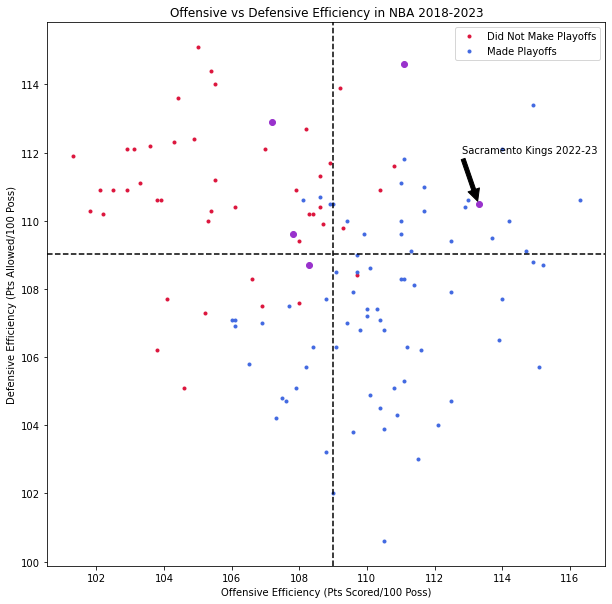

In [35]:
#create comparison for offensive and defensive efficiency
comparison_plot(fullnbastats, fullnbastats.columns.get_loc("OFF EFF"), fullnbastats.columns.get_loc("DEF EFF"), -0.5, 1.5)
plt.xlabel("Offensive Efficiency (Pts Scored/100 Poss)")
plt.ylabel("Defensive Efficiency (Pts Allowed/100 Poss)")
plt.title("Offensive vs Defensive Efficiency in NBA 2018-2023")
plt.show()

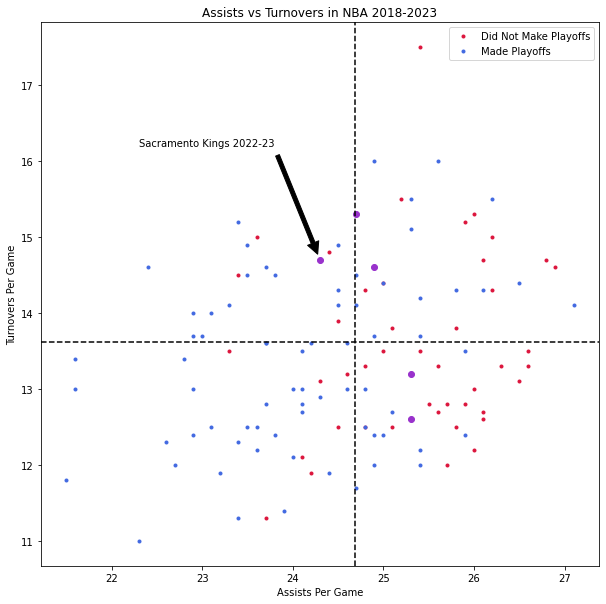

In [36]:
#create comparison for assists and turnovers
comparison_plot(fullnbastats, fullnbastats.columns.get_loc("AST"), fullnbastats.columns.get_loc("TO"), -2, 1.5)
plt.xlabel("Assists Per Game")
plt.ylabel("Turnovers Per Game")
plt.title("Assists vs Turnovers in NBA 2018-2023")
plt.show()

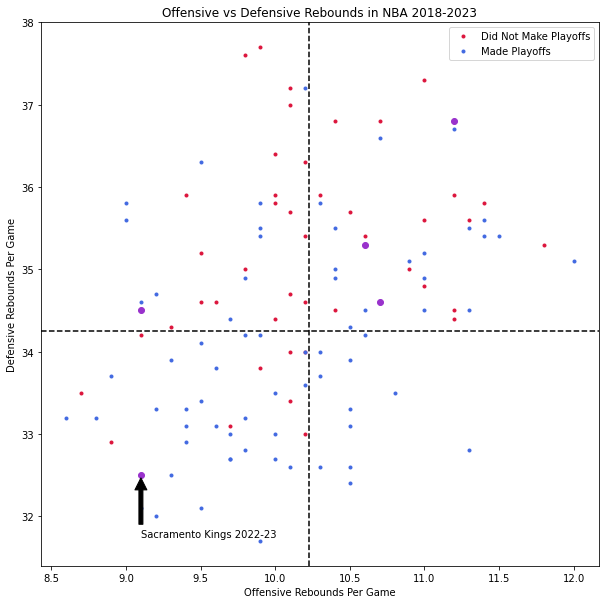

In [37]:
#create comparison for offensive and defensive rebounds
comparison_plot(fullnbastats, fullnbastats.columns.get_loc("OR"), fullnbastats.columns.get_loc("DR"), 0, -0.75)
plt.xlabel("Offensive Rebounds Per Game")
plt.ylabel("Defensive Rebounds Per Game")
plt.title("Offensive vs Defensive Rebounds in NBA 2018-2023")
plt.show()

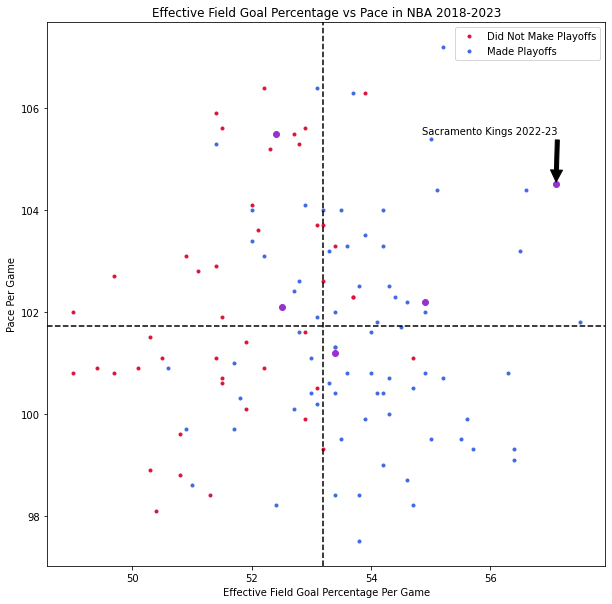

In [38]:
#create comparison for effective field goal % and pace
comparison_plot(fullnbastats, fullnbastats.columns.get_loc("EFF FG%"), fullnbastats.columns.get_loc("PACE"), -2.25, 1)
plt.xlabel("Effective Field Goal Percentage Per Game")
plt.ylabel("Pace Per Game")
plt.title("Effective Field Goal Percentage vs Pace in NBA 2018-2023")
plt.show()

## Linear Regression

### DATA CLEANING

In [39]:
#Non-kings player data
df = player_stats_shoot_salary_temp
df_names = df["Name"]
df.head(30)

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,Nikola Jokic,21,21.0,32.2,23.0,1.9,8.1,10.0,8.9,1.3,0.6,3.2,2.9,2.7,8.6,13.7,63.1,0.8,2.4,32.0,5.0,6.2,80.8,7.9,11.3,69.6,1.683,0.66,33047804.0
1,Jamal Murray,20,20.0,29.9,17.6,0.5,3.2,3.7,5.0,1.0,0.3,2.0,1.5,2.5,6.6,15.3,43.3,1.9,5.3,36.2,2.5,3.2,78.1,4.7,10.0,47.0,1.154,0.50,31650000.0
2,Aaron Gordon,21,21.0,29.3,16.6,2.4,4.3,6.7,2.3,0.7,0.8,1.4,1.8,1.6,6.4,10.3,61.8,1.1,2.8,39.7,2.8,4.3,63.7,5.3,7.6,69.8,1.608,0.67,19690909.0
4,Bones Hyland,16,0.0,21.1,14.4,0.3,1.8,2.1,3.4,0.7,0.3,1.9,1.7,1.8,4.8,11.8,40.4,2.8,6.4,44.1,2.1,2.6,81.0,1.9,5.4,36.0,1.229,0.52,2201520.0
5,Bruce Brown,24,12.0,30.0,11.3,1.0,3.5,4.5,4.5,1.1,0.5,1.8,2.5,2.5,4.4,9.4,47.1,1.4,3.4,40.7,1.0,1.2,89.3,3.0,6.0,50.7,1.200,0.54,6479000.0
6,Kentavious Caldwell-Pope,23,23.0,31.1,11.0,0.5,2.3,2.9,2.1,1.2,0.4,1.3,2.0,1.6,3.9,8.4,46.4,2.1,4.6,45.7,1.1,1.4,78.1,1.8,3.9,47.2,1.304,0.59,14004703.0
7,Jeff Green,17,3.0,19.8,7.9,0.7,1.8,2.5,1.2,0.4,0.2,1.0,2.1,1.2,2.9,5.5,53.8,0.4,1.3,27.3,1.6,2.2,75.7,2.6,4.2,62.0,1.441,0.57,4500000.0
8,DeAndre Jordan,19,3.0,15.7,5.3,1.6,4.3,5.9,1.0,0.2,0.6,1.3,1.6,0.8,2.3,3.0,75.4,0.1,0.1,100.0,0.7,1.6,46.7,2.2,2.9,75.0,1.772,0.76,1836090.0
9,Vlatko Cancar,16,0.0,12.4,5.0,0.3,1.4,1.8,0.9,0.4,0.3,0.6,1.4,1.5,1.9,4.1,46.2,0.9,2.1,41.2,0.4,0.4,85.7,1.0,1.9,51.6,1.231,0.57,2234359.0
10,Zeke Nnaji,18,0.0,10.1,4.3,0.9,0.4,1.4,0.2,0.2,0.2,0.5,1.4,0.4,1.8,3.1,58.9,0.2,0.8,21.4,0.4,0.6,80.0,1.7,2.3,71.4,1.375,0.62,2498760.0


In [40]:
#Kings data
kings_df = kings_final_df
kings_df

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,De'Aaron Fox,21,21.0,31.7,23.1,0.5,4.6,5.1,5.8,1.1,0.5,2.6,2.5,2.2,8.6,16.6,51.6,1.9,5.0,38.1,4.1,5.0,81.9,6.7,11.6,57.4,1.393,0.57,"$28,103,550"
1,Domantas Sabonis,22,22.0,32.0,16.7,2.2,8.8,11.0,6.5,0.7,0.5,2.5,3.8,2.6,6.0,10.1,59.9,0.5,1.2,37.0,4.2,5.5,75.4,5.6,8.9,63.1,1.658,0.62,"$18,500,000"
2,Kevin Huerter,22,22.0,31.8,15.5,0.4,2.8,3.2,3.2,1.0,0.4,1.5,2.4,2.2,5.5,11.5,47.4,3.0,7.1,42.3,1.6,2.4,69.2,2.5,4.4,55.7,1.352,0.60,"$14,508,929"
3,Malik Monk,22,0.0,22.3,14.7,0.4,1.7,2.1,4.3,0.7,0.2,1.9,1.8,2.3,5.4,11.0,48.8,2.1,5.7,36.8,1.9,2.1,89.4,3.3,5.3,61.5,1.339,0.58,"$9,472,219"
4,Harrison Barnes,22,22.0,30.6,13.2,1.0,4.4,5.5,1.9,0.9,0.1,1.2,1.4,1.5,4.1,8.4,48.9,1.0,3.3,30.1,4.0,4.8,84.0,3.1,5.0,61.3,1.582,0.55,"$18,352,273"
5,Keegan Murray,20,18.0,28.4,11.3,0.9,3.2,4.1,0.9,0.8,0.6,1.6,2.1,0.6,4.1,9.9,41.4,1.9,5.7,33.3,1.2,1.4,85.2,2.2,4.2,52.4,1.136,0.51,"$8,008,440"
6,Terence Davis,20,1.0,13.2,7.0,0.5,2.6,3.0,1.5,0.8,0.2,0.8,1.8,2.0,2.5,5.6,43.8,1.4,3.6,39.4,0.7,0.8,87.5,1.1,2.1,51.2,1.250,0.56,"$4,000,000"
7,Davion Mitchell,22,1.0,19.2,6.7,0.1,1.3,1.4,2.3,0.5,0.2,1.0,1.6,2.2,2.7,6.0,44.7,0.8,2.7,30.5,0.5,0.7,73.3,1.9,3.3,56.2,1.114,0.52,"$4,833,600"
8,Trey Lyles,17,0.0,14.2,6.3,1.0,1.8,2.8,0.8,0.4,0.4,1.0,1.2,0.8,2.1,5.1,40.7,1.2,3.6,34.4,0.9,1.3,72.7,0.8,1.5,56.0,1.244,0.53,"$2,700,000"
9,Chimezie Metu,18,0.0,12.6,5.9,0.7,2.8,3.5,0.8,0.3,0.3,0.7,1.2,1.2,2.5,4.0,62.5,0.2,0.9,18.8,0.8,0.9,87.5,2.3,3.1,75.0,1.486,0.65,"$1,910,680"


In [41]:
def df_clean(df):
    #Dropping name to enable linear regression
    df = df.drop("Name", axis = "columns").dropna()
    # AST/TO has some infinities, dropping them
    drop_df = df[df["AST/TO"].isin([np.inf, -np.inf])]
    df = df.drop(drop_df.index)
    for name in df.columns:
        # Dropping, as these variables are made redundant by their corresponding percentages: (FG%, 2P%, ...)
        if name in ["FGM","FGA","3PM","3PA","2PM","2PA","FTM","FTA"]:
            df = df.drop(name, axis = "columns") 
    return df


In [42]:
#cleaning df
df = df_clean(df)
df.head(30)

,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FG%,3P%,FT%,2P%,SC-EFF,SH-EFF,Salary
0,21,21.0,32.2,23.0,1.9,8.1,10.0,8.9,1.3,0.6,3.2,2.9,2.7,63.1,32.0,80.8,69.6,1.683,0.66,33047804.0
1,20,20.0,29.9,17.6,0.5,3.2,3.7,5.0,1.0,0.3,2.0,1.5,2.5,43.3,36.2,78.1,47.0,1.154,0.50,31650000.0
2,21,21.0,29.3,16.6,2.4,4.3,6.7,2.3,0.7,0.8,1.4,1.8,1.6,61.8,39.7,63.7,69.8,1.608,0.67,19690909.0
4,16,0.0,21.1,14.4,0.3,1.8,2.1,3.4,0.7,0.3,1.9,1.7,1.8,40.4,44.1,81.0,36.0,1.229,0.52,2201520.0
5,24,12.0,30.0,11.3,1.0,3.5,4.5,4.5,1.1,0.5,1.8,2.5,2.5,47.1,40.7,89.3,50.7,1.200,0.54,6479000.0
6,23,23.0,31.1,11.0,0.5,2.3,2.9,2.1,1.2,0.4,1.3,2.0,1.6,46.4,45.7,78.1,47.2,1.304,0.59,14004703.0
7,17,3.0,19.8,7.9,0.7,1.8,2.5,1.2,0.4,0.2,1.0,2.1,1.2,53.8,27.3,75.7,62.0,1.441,0.57,4500000.0
8,19,3.0,15.7,5.3,1.6,4.3,5.9,1.0,0.2,0.6,1.3,1.6,0.8,75.4,100.0,46.7,75.0,1.772,0.76,1836090.0
9,16,0.0,12.4,5.0,0.3,1.4,1.8,0.9,0.4,0.3,0.6,1.4,1.5,46.2,41.2,85.7,51.6,1.231,0.57,2234359.0
10,18,0.0,10.1,4.3,0.9,0.4,1.4,0.2,0.2,0.2,0.5,1.4,0.4,58.9,21.4,80.0,71.4,1.375,0.62,2498760.0


### MODEL BUILDING

In [43]:
df = sm.add_constant(df)

In [44]:
#build ols model
ols = sm.OLS(np.log(df['Salary']),df.drop(columns = 'Salary')) 
ols_res = ols.fit() 

In [45]:
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     8.038
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           2.07e-15
Time:                        22:36:14   Log-Likelihood:                -240.59
No. Observations:                 184   AIC:                             521.2
Df Residuals:                     164   BIC:                             585.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.5465      0.505     28.827      0.000      13.550      15.543
GP            -0.0064      0.016     -0.392      0.695      -0.038       0.026
GS             0.0095      0.015      0.651      0.516      -0.019       0.038
MIN            0.0529      0.026      2.031      0.044       0.001       0.104
PTS            0.0183      0.025      0.723      0.470      -0.032       0.068
OR            -0.7116      1.461     -0.487      0.627      -3.597       2.174
DR            -0.3975      1.494     -0.266      0.791      -3.348       2.553
REB            0.5401      1.480      0.365      0.716      -2.383       3.463
AST            0.0861      0.107      0.809      0.420      -0.124       0.296
STL           -0.3516      0.289     -1.218      0.225      -0.921       0.218
BLK            0.1818      0.260      0.699      0.485      -0.331       0.695
TO             0.0130      0.247      0.053      0.958      -0.476       0.502
PF             0.0784      0.139      0.564      0.574      -0.196       0.353
AST/TO        -0.0563      0.116     -0.486      0.627      -0.285       0.172
FG%           -0.0174      0.029     -0.603      0.547      -0.074       0.039
3P%           -0.0055      0.007     -0.771      0.442      -0.020       0.009
FT%            0.0011      0.005      0.221      0.826      -0.009       0.011
2P%            0.0070      0.009      0.784      0.434      -0.011       0.025
SC-EFF        -0.2135      0.720     -0.296      0.767      -1.636       1.209
SH-EFF         0.1971      2.699      0.073      0.942      -5.132       5.526
==============================================================================
Omnibus:                       98.732   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.386
Skew:                          -1.849   Prob(JB):                    1.15e-168
Kurtosis:                      12.338   Cond. No.                     4.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### The drops below were intentionally done one at a time, as a part of model selection. We checked how dropping each variable affected the other p-values.

In [46]:
df = df.drop("OR", axis = "columns")

In [47]:
df = df.drop("STL", axis = "columns")

In [48]:
df = df.drop("PF", axis = "columns")

In [49]:
df = df.drop("TO", axis = "columns")

In [50]:
df = df.drop("BLK", axis = "columns") #.473

In [51]:
df = df.drop("FG%", axis = "columns")

In [52]:
df = df.drop("AST/TO", axis = "columns")

In [53]:
df = df.drop("SH-EFF", axis = "columns")

In [54]:
df = df.drop("GS", axis = "columns") #.482

In [55]:
df = df.drop("REB", axis = "columns") 

In [56]:
df = df.drop("3P%", axis = "columns")

### MODELING

In [57]:
#Setting up and running linear regression
#Log transform salary due to salary's right skew
ols = sm.OLS(np.log(df['Salary']),df.drop(columns = 'Salary')) 
ols_res = ols.fit() 
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     18.72
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           3.91e-20
Time:                        22:36:14   Log-Likelihood:                -244.26
No. Observations:                 184   AIC:                             506.5
Df Residuals:                     175   BIC:                             535.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3189      0.448     31.945      0.000      13.434      15.204
GP            -0.0079      0.015     -0.516      0.607      -0.038       0.022
MIN            0.0454      0.019      2.410      0.017       0.008       0.083
PTS            0.0324      0.021      1.568      0.119      -0.008       0.073
DR             0.1278      0.060      2.126      0.035       0.009       0.246
AST            0.0536      0.054      0.985      0.326      -0.054       0.161
FT%            0.0029      0.004      0.688      0.492      -0.005       0.011
2P%            0.0064      0.008      0.848      0.397      -0.008       0.021
SC-EFF        -0.8054      0.388     -2.077      0.039      -1.571      -0.040
==============================================================================
Omnibus:                       97.519   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.354
Skew:                          -1.808   Prob(JB):                    7.89e-171
Kurtosis:                      12.439   Cond. No.                         680.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### DIAGNOSTIC PLOTS

C:\Users\Jonathan\anaconda3\lib\site-packages\plotnine\stats\smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


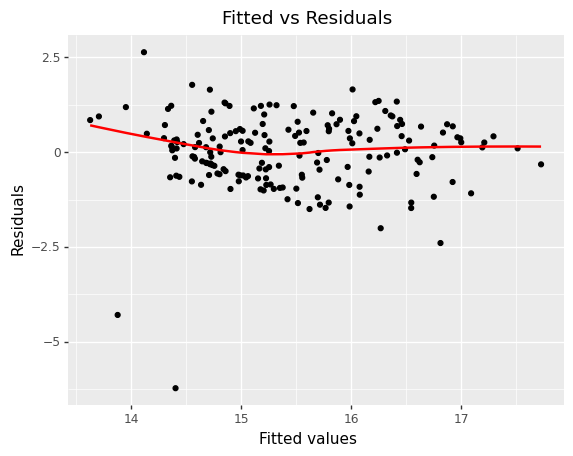

<ggplot: (164566727885)>

In [58]:
#fitted vs residual plot

(
    p9.ggplot(mapping = p9.aes(x = 'ols_res.fittedvalues', 
                                            y = "ols_res.resid_pearson"))
    + p9.geom_point()
    + p9.geom_smooth(color = "red")
    + p9.labs(title = "Fitted vs Residuals", x = 'Fitted values', y = 'Residuals')
)

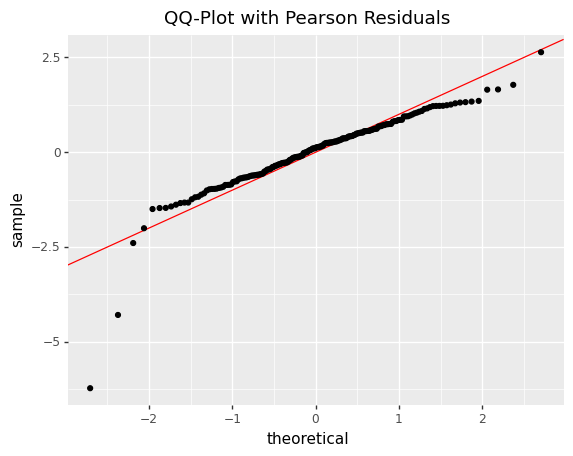

<ggplot: (164566801469)>

In [59]:
#qq-plot

(
    p9.ggplot(mapping = p9.aes(sample = "ols_res.resid_pearson"))
    + p9.geom_abline(p9.aes(intercept = 0, slope = 1), color = 'red')
    + p9.stats.stat_qq()
    + p9.labs(title = "QQ-Plot with Pearson Residuals")
)

### REMOVE OUTLIERS

In [60]:
df["Residuals"] = ols_res.resid_pearson
temp_df2 = df[round(df["Residuals"]) < -2]
#row with residual outliers
temp_df2

,const,GP,MIN,PTS,DR,AST,FT%,2P%,SC-EFF,Salary,Residuals
191,1.0,17,5.9,4.1,1.6,0.1,51.3,65.8,1.842,19186.0,-4.292991
250,1.0,9,13.8,4.4,1.0,1.1,66.7,25.0,1.429,5318.0,-6.226199


In [61]:
# drop outlier rows
df = df.drop(temp_df2.index)
df = df.drop("Residuals", axis = "columns")

In [62]:
#rerun model without outliers
ols = sm.OLS(np.log(df['Salary']),df.drop(columns = 'Salary')) 
ols_res = ols.fit() 
ols_res.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     24.69
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           4.38e-25
Time:                        22:36:15   Log-Likelihood:                -199.83
No. Observations:                 182   AIC:                             417.7
Df Residuals:                     173   BIC:                             446.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.4554      0.358     40.405      0.000      13.749      15.162
GP            -0.0141      0.012     -1.139      0.256      -0.038       0.010
MIN            0.0430      0.015      2.844      0.005       0.013       0.073
PTS            0.0286      0.016      1.735      0.084      -0.004       0.061
DR             0.1064      0.048      2.223      0.028       0.012       0.201
AST            0.0555      0.043      1.282      0.201      -0.030       0.141
FT%           -0.0003      0.003     -0.101      0.919      -0.007       0.006
2P%           -0.0103      0.006     -1.655      0.100      -0.023       0.002
SC-EFF         0.2254      0.325      0.695      0.488      -0.415       0.866
==============================================================================
Omnibus:                        2.275   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.321   Jarque-Bera (JB):                2.331
Skew:                          -0.261   Prob(JB):                        0.312
Kurtosis:                       2.812   Cond. No.                         685.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\Jonathan\anaconda3\lib\site-packages\plotnine\stats\smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


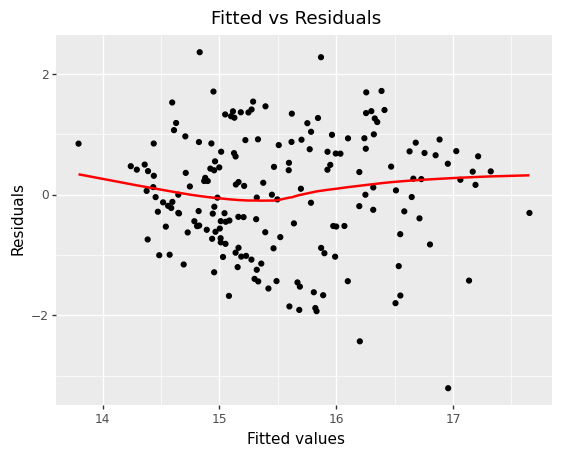

<ggplot: (164566847004)>

In [63]:
#fitted vs residuals

(
    p9.ggplot(mapping = p9.aes(x = 'ols_res.fittedvalues', 
                                            y = "ols_res.resid_pearson"))
    + p9.geom_point()
    + p9.geom_smooth(color = "red")
    + p9.labs(title = "Fitted vs Residuals", x = 'Fitted values', y = 'Residuals')
)

##### Homoscedascity assumption satisfied

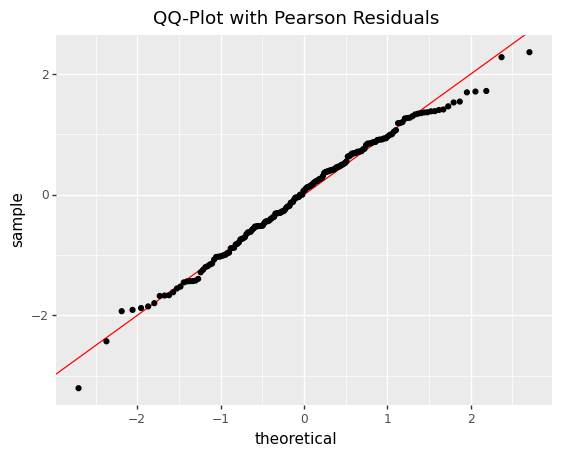

<ggplot: (164566881726)>

In [64]:
##qq plot

(
    p9.ggplot(mapping = p9.aes(sample = "ols_res.resid_pearson"))
    + p9.geom_abline(p9.aes(intercept = 0, slope = 1), color = 'red')
    + p9.stats.stat_qq()
    + p9.labs(title = "QQ-Plot with Pearson Residuals")
)

##### Normality of error variances assumption satisfied

### Running the Model on the Kings

In [65]:
kings_df

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,De'Aaron Fox,21,21.0,31.7,23.1,0.5,4.6,5.1,5.8,1.1,0.5,2.6,2.5,2.2,8.6,16.6,51.6,1.9,5.0,38.1,4.1,5.0,81.9,6.7,11.6,57.4,1.393,0.57,"$28,103,550"
1,Domantas Sabonis,22,22.0,32.0,16.7,2.2,8.8,11.0,6.5,0.7,0.5,2.5,3.8,2.6,6.0,10.1,59.9,0.5,1.2,37.0,4.2,5.5,75.4,5.6,8.9,63.1,1.658,0.62,"$18,500,000"
2,Kevin Huerter,22,22.0,31.8,15.5,0.4,2.8,3.2,3.2,1.0,0.4,1.5,2.4,2.2,5.5,11.5,47.4,3.0,7.1,42.3,1.6,2.4,69.2,2.5,4.4,55.7,1.352,0.60,"$14,508,929"
3,Malik Monk,22,0.0,22.3,14.7,0.4,1.7,2.1,4.3,0.7,0.2,1.9,1.8,2.3,5.4,11.0,48.8,2.1,5.7,36.8,1.9,2.1,89.4,3.3,5.3,61.5,1.339,0.58,"$9,472,219"
4,Harrison Barnes,22,22.0,30.6,13.2,1.0,4.4,5.5,1.9,0.9,0.1,1.2,1.4,1.5,4.1,8.4,48.9,1.0,3.3,30.1,4.0,4.8,84.0,3.1,5.0,61.3,1.582,0.55,"$18,352,273"
5,Keegan Murray,20,18.0,28.4,11.3,0.9,3.2,4.1,0.9,0.8,0.6,1.6,2.1,0.6,4.1,9.9,41.4,1.9,5.7,33.3,1.2,1.4,85.2,2.2,4.2,52.4,1.136,0.51,"$8,008,440"
6,Terence Davis,20,1.0,13.2,7.0,0.5,2.6,3.0,1.5,0.8,0.2,0.8,1.8,2.0,2.5,5.6,43.8,1.4,3.6,39.4,0.7,0.8,87.5,1.1,2.1,51.2,1.250,0.56,"$4,000,000"
7,Davion Mitchell,22,1.0,19.2,6.7,0.1,1.3,1.4,2.3,0.5,0.2,1.0,1.6,2.2,2.7,6.0,44.7,0.8,2.7,30.5,0.5,0.7,73.3,1.9,3.3,56.2,1.114,0.52,"$4,833,600"
8,Trey Lyles,17,0.0,14.2,6.3,1.0,1.8,2.8,0.8,0.4,0.4,1.0,1.2,0.8,2.1,5.1,40.7,1.2,3.6,34.4,0.9,1.3,72.7,0.8,1.5,56.0,1.244,0.53,"$2,700,000"
9,Chimezie Metu,18,0.0,12.6,5.9,0.7,2.8,3.5,0.8,0.3,0.3,0.7,1.2,1.2,2.5,4.0,62.5,0.2,0.9,18.8,0.8,0.9,87.5,2.3,3.1,75.0,1.486,0.65,"$1,910,680"


In [66]:
#replace all the "--" and NAN to 0

kings_df['Salary'] = kings_df['Salary'].replace("--", '0')
kings_df['Salary'] = kings_df['Salary'].replace(np.NaN, '0')
#remove $ and , signals
for i in range(0,len(kings_df)):
    kings_df['Salary'][i] = kings_df['Salary'][i].lstrip('$')
    kings_df['Salary'][i] = kings_df['Salary'][i].replace(',','')
    #turn Salary to numbers
    kings_df['Salary'][i] = int(kings_df['Salary'][i])
#replace all 0 to NAN
kings_df['Salary'] = kings_df['Salary'].replace(0, np.NaN)
#drop all NAN
kings_df = kings_df.dropna()

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_2368\1469477879.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_2368\1469477879.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_2368\1469477879.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [67]:
kings_names = kings_df["Name"]

In [68]:
kings_df = df_clean(kings_df)

In [69]:
#Dropped same variables as from non-kings dataframe
kings_df = kings_df.drop("OR", axis = "columns")
kings_df = kings_df.drop("STL", axis = "columns")
kings_df = kings_df.drop("PF", axis = "columns")
kings_df = kings_df.drop("TO", axis = "columns")
kings_df = kings_df.drop("BLK", axis = "columns")
kings_df = kings_df.drop("FG%", axis = "columns")
kings_df = kings_df.drop("AST/TO", axis = "columns")
kings_df = kings_df.drop("SH-EFF", axis = "columns")
kings_df = kings_df.drop("GS", axis = "columns")
kings_df = kings_df.drop("REB", axis = "columns") 
kings_df = kings_df.drop("3P%", axis = "columns")

In [70]:
kings_df = sm.add_constant(kings_df)
kings_df["GP"] = kings_df["GP"].astype("float64")


In [71]:
#predicted salary values
ols_res.predict(kings_df.drop(columns = 'Salary'))

0     16.689034
1     16.993472
2     16.138548
3     15.581874
4     16.108263
5     15.795086
6     15.025623
7     15.075503
8     14.921072
9     14.786877
10    14.601704
11    14.552566
13    14.654382
14    14.365719
dtype: float64

In [72]:
#Creating predicted and residuals columns
kings_df["Predicted"] = np.exp(ols_res.predict(kings_df.drop(columns = 'Salary')))
kings_df.insert(0,"Names",kings_names)
kings_df["Residuals"]= kings_df["Salary"]-kings_df["Predicted"]

In [73]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
kings_df

,Names,const,GP,MIN,PTS,DR,AST,FT%,2P%,SC-EFF,Salary,Predicted,Residuals
0,De'Aaron Fox,1.00000,21.00000,31.70000,23.10000,4.60000,5.80000,81.90000,57.40000,1.39300,28103550.00000,17699275.41955,10404274.58045
1,Domantas Sabonis,1.00000,22.00000,32.00000,16.70000,8.80000,6.50000,75.40000,63.10000,1.65800,18500000.00000,23997790.05226,-5497790.05226
2,Kevin Huerter,1.00000,22.00000,31.80000,15.50000,2.80000,3.20000,69.20000,55.70000,1.35200,14508929.00000,10206624.63667,4302304.36333
3,Malik Monk,1.00000,22.00000,22.30000,14.70000,1.70000,4.30000,89.40000,61.50000,1.33900,9472219.00000,5849542.86953,3622676.13047
4,Harrison Barnes,1.00000,22.00000,30.60000,13.20000,4.40000,1.90000,84.00000,61.30000,1.58200,18352273.00000,9902157.55477,8450115.44523
5,Keegan Murray,1.00000,20.00000,28.40000,11.30000,3.20000,0.90000,85.20000,52.40000,1.13600,8008440.00000,7239665.25788,768774.74212
6,Terence Davis,1.00000,20.00000,13.20000,7.00000,2.60000,1.50000,87.50000,51.20000,1.25000,4000000.00000,3353861.18108,646138.81892
7,Davion Mitchell,1.00000,22.00000,19.20000,6.70000,1.30000,2.30000,73.30000,56.20000,1.11400,4833600.00000,3525394.58431,1308205.41569
8,Trey Lyles,1.00000,17.00000,14.20000,6.30000,1.80000,0.80000,72.70000,56.00000,1.24400,2700000.00000,3020918.64272,-320918.64272
9,Chimezie Metu,1.00000,18.00000,12.60000,5.90000,2.80000,0.80000,87.50000,75.00000,1.48600,1910680.00000,2641550.24948,-730870.24948


In [74]:
#Team overall is overvalued
kings_df["Residuals"].sum()

30472497.478510216

In [75]:
#Dataframe with log values instead
kings_df["Salary"] = np.log(kings_df["Salary"])
kings_df["Predicted"] =  np.log(kings_df["Predicted"])
kings_df["Residuals"]= kings_df["Salary"]-kings_df["Predicted"]
kings_df

,Names,const,GP,MIN,PTS,DR,AST,FT%,2P%,SC-EFF,Salary,Predicted,Residuals
0,De'Aaron Fox,1.00000,21.00000,31.70000,23.10000,4.60000,5.80000,81.90000,57.40000,1.39300,17.15141,16.68903,0.46237
1,Domantas Sabonis,1.00000,22.00000,32.00000,16.70000,8.80000,6.50000,75.40000,63.10000,1.65800,16.73328,16.99347,-0.26019
2,Kevin Huerter,1.00000,22.00000,31.80000,15.50000,2.80000,3.20000,69.20000,55.70000,1.35200,16.49027,16.13855,0.35173
3,Malik Monk,1.00000,22.00000,22.30000,14.70000,1.70000,4.30000,89.40000,61.50000,1.33900,16.06387,15.58187,0.48200
4,Harrison Barnes,1.00000,22.00000,30.60000,13.20000,4.40000,1.90000,84.00000,61.30000,1.58200,16.72526,16.10826,0.61700
5,Keegan Murray,1.00000,20.00000,28.40000,11.30000,3.20000,0.90000,85.20000,52.40000,1.13600,15.89601,15.79509,0.10092
6,Terence Davis,1.00000,20.00000,13.20000,7.00000,2.60000,1.50000,87.50000,51.20000,1.25000,15.20180,15.02562,0.17618
7,Davion Mitchell,1.00000,22.00000,19.20000,6.70000,1.30000,2.30000,73.30000,56.20000,1.11400,15.39110,15.07550,0.31560
8,Trey Lyles,1.00000,17.00000,14.20000,6.30000,1.80000,0.80000,72.70000,56.00000,1.24400,14.80876,14.92107,-0.11231
9,Chimezie Metu,1.00000,18.00000,12.60000,5.90000,2.80000,0.80000,87.50000,75.00000,1.48600,14.46297,14.78688,-0.32391


In [76]:
# log version
kings_df["Residuals"].sum()

2.5176904446235273

## Logistic Regression

### Multicollinearity

In [77]:
#drop first 30 rows (current season which we do not want)
#drop "made playoffs" (response), "team" (unique identifier), and "GP" (GP = W + L, so causing issue being a linear combination)
x = fullnbastats[30:].drop(columns = ['Made Playoffs', 'Team', 'GP'])
y= fullnbastats["Made Playoffs"][30:]
#compute vifs for each variable to determine which can be used
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif.round(1)

,VIF Factor,features
0,153.60000,W
1,110.60000,L
2,2954414.10000,PTS
3,2058831.50000,FGM
4,307394.40000,FGA
5,598471.90000,FG%
6,101597.80000,3PM
7,83669.50000,3PA
8,88453.40000,3P%
9,180255.50000,FTM


### Standardization

In [78]:
#standardize data by centering each variable by respective mean
standardizeddata = fullnbastats.drop(columns = ['Made Playoffs', 'Team'])
colnames = standardizeddata.columns
standardizeddata = pd.DataFrame(preprocessing.scale(standardizeddata))
standardizeddata.columns = colnames
standardizeddata

,W,L,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF,PACE,EFF FG%,OFF EFF,DEF EFF
0,-0.82626,-1.95813,-1.90471,0.23055,0.71374,0.53305,0.39919,-0.84905,-0.81387,-0.27397,-0.27009,-0.42558,0.52000,-0.15632,-0.70522,-0.57844,-2.01710,-1.81679,-1.64257,-0.90994,0.11413,-0.41095,3.17015,2.92081,0.30638
1,-1.03033,-1.88856,-1.99729,-1.06024,-0.67494,0.61709,-1.31982,-1.14182,-0.97578,-0.71194,-0.45999,-0.62872,0.72365,0.09050,-0.63776,-0.47039,-2.54304,-1.53008,-0.10841,-0.74726,-0.20144,0.08327,0.05358,-0.06168,-1.19754
2,-1.16638,-1.67986,-1.90471,-1.84010,-1.73298,-1.65182,-0.67519,-1.14182,-0.89483,-0.93093,-0.20679,-0.12087,-0.56616,-1.02017,-2.45928,-2.41532,-1.56630,0.04683,-0.56866,0.79823,1.13976,-2.47768,0.81906,0.66873,-1.47734
3,-1.30243,-1.47115,-1.90471,-0.44174,-1.20396,-0.05518,-1.46307,0.41964,-0.12575,1.25892,0.93265,1.35190,-1.51655,1.94161,-0.84015,0.17793,-1.34090,0.33354,-1.18233,-0.01518,-1.14817,-0.54574,1.80324,0.63829,-0.42809
4,-1.37045,-1.47115,-1.95100,0.49947,0.18472,-0.05518,0.25594,-1.53219,-0.77339,-1.95285,1.75557,1.40268,1.74192,0.95435,0.03688,0.44805,-0.43928,-0.81330,0.19842,0.87957,0.58750,0.66734,-0.65721,0.12092,0.06156
5,-1.37045,-1.47115,-1.95100,1.11797,-0.01367,-0.26527,0.25594,0.61483,0.35998,0.74795,2.19868,1.60582,2.62443,0.95435,0.03688,0.44805,0.83800,0.19018,0.96550,1.61165,0.42971,1.61085,-0.16512,-0.27471,0.72608
6,-1.37045,-1.47115,-1.95100,-0.52241,-0.80720,-2.61820,1.47357,-0.06831,0.07664,-0.27397,0.36293,0.03149,1.47038,-1.14358,-1.17747,-1.44285,1.28880,-1.53008,0.50525,2.50640,0.66639,-0.63559,-1.25866,0.09049,0.23643
7,-1.43848,-1.47115,-1.95100,-1.11403,-1.00558,-1.77787,0.39919,-1.53219,-0.69244,-2.17184,0.29963,0.38698,-0.49827,-0.40313,-0.84015,-0.79454,-0.66469,-0.95666,0.35183,1.04226,-0.67481,-1.21967,0.60035,0.18179,-0.63794
8,-1.43848,-1.40158,-1.95100,0.87595,0.11859,1.16330,-0.89006,1.59074,2.14100,-0.49296,0.80604,1.09797,-1.10924,2.43525,-0.09805,0.98831,1.51421,-1.53008,0.19842,-0.09653,0.66639,0.44270,-1.09463,0.06006,0.48125
9,-1.50650,-1.33201,-1.90471,-0.41485,-0.14592,-0.93753,0.68569,1.39556,1.65527,-0.12798,-1.66273,-1.74599,0.04480,-1.14358,-0.09805,-0.57844,0.98827,-1.38672,-1.18233,1.36762,0.35082,-1.66896,-0.71189,-0.51818,-0.28819


In [79]:
#cut df to not include current season. run vif and drop variables one by one until all vifs are <10
x = standardizeddata[30:]
x = x.drop(columns = ['GP', 'FGM', 'FGA', 'FTM', 'FTA', '3PM', '3PA', 'REB', 'PACE', 'OFF EFF', 'DEF EFF'])
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif.round(1)

,VIF Factor,features
0,3.30000,W
1,4.00000,L
2,7.30000,PTS
3,3.90000,FG%
4,3.00000,3P%
5,1.20000,FT%
6,1.80000,OR
7,3.10000,DR
8,2.20000,AST
9,1.90000,STL


### Building The Model

In [80]:
#create train/test data using 80:20 ratio
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [81]:
#build our model using train/test data. see what the accuracy is
model = LogisticRegression(solver='liblinear', C = 10, random_state=0, max_iter = 1000)
model.fit(x_train, y_train)
model.classes_
model.intercept_
model.coef_
model.predict_proba(x_test)
model.predict(x_test)
print("Model Accuracy:", model.score(x_test, y_test))

Model Accuracy: 0.9166666666666666


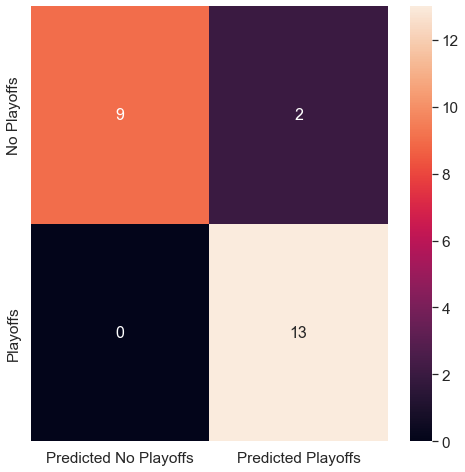

In [82]:
#build a confusion matrix to see how our model is performing
cm = confusion_matrix(y_test, model.predict(x_test))
df_cm = pd.DataFrame(cm, ['No Playoffs', 'Playoffs'], ['Predicted No Playoffs', 'Predicted Playoffs'])
plt.figure(figsize=(8,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

### Running Model on Kings

In [83]:
#run our model specifically on Kings 22-23 data to see if they make playoffs or not
kingsfullnbastats23 = standardizeddata.iloc[kingsindex,:].drop(columns = ['GP', 'FGM', 'FGA', 'FTM', 'FTA', '3PM', '3PA', 'REB', 'PACE', 'OFF EFF', 'DEF EFF'])
print("Kings Probability of Not Making Playoffs:", model.predict_proba(kingsfullnbastats23)[0][0])
print("Kings Probability of Making Playoffs:", model.predict_proba(kingsfullnbastats23)[0][1])
print("Will Kings Make Playoffs?: (0 if no, 1 if yes)", model.predict(kingsfullnbastats23)[0])

Kings Probability of Not Making Playoffs: 0.39157949783644996
Kings Probability of Making Playoffs: 0.60842050216355
Will Kings Make Playoffs?: (0 if no, 1 if yes) 1.0
